# Anylsis Pipeline for the project
Team Dog: Maximilian Bernhardt, Patrick Ebner, Simon Enkel, Claudius Hilser, Enno Schwenk

* **Beschreibung der Pipeline nach Fertigstellung**



### Imports

In [244]:
#Import packages
import numpy as np
import pandas as pd
import os, re
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

### Data read-in

In [202]:
# Define path for folder with participant data
folder_path = '../data/raw'

# Save all filenames in a list
tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]


### Defining variables, dataframes and lists

In [203]:
# Define target coordinates
target_coords = [
    (-320, 0), (320, 0), (-277, -160), (277, 160), 
    (0, 320), (0, -320), (277, -160), (-277, 160), 
    (-160, -277), (160, 277), (160, -277), (-160, 277)
]
# Define target names according to the coordinates
target_names = [
    'nine', 'three', 'eight', 'two', 
    'twelve', 'six', 'four', 'ten', 
    'seven', 'one', 'five', 'eleven'
]
target_coord_to_name = dict(zip(target_coords, target_names))

# Ensure the dataframe is in the correct order from one to twelve
target_order = [
    'one', 'two', 'three', 'four', 
    'five', 'six', 'seven', 'eight', 
    'nine', 'ten', 'eleven', 'twelve'
]

# Save screen-dimensions and threshold to define whether a target was fixated or not
screen_width = 1920
screen_height = 1080
threshold = 65

# Initialize an empty dataframe for the sums of fixations
sum_df = pd.DataFrame(columns=['Coordinate', 'Count'])

# Define pairs for stimuli belonging together
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), ('eleven', 'five'), ('twelve', 'six')]

# Count all fixations for each participant
fixation_count = []

### Defining Functions
All functions used for the visualizing the results of the research are defined in the following blocks. 

**find_closest_target(row, target_coords, threshold)** \
The second function finds the stimuli which the the fixation lands on.




In [324]:
# Function to find the closest target coordinate within the threshold distance
def find_closest_target(row, target_coords, threshold):
    x, y = row['x_coord'], row['y_coord']
    for tx, ty in target_coords:
        if np.sqrt((x - tx)**2 + (y - ty)**2) <= threshold:
            return (tx, ty)
    return None

# Function 3
def check_balancing_errors(df):
    # Count the occurrences of each unique value in the 'USER' column
    
    event_counts = df['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    
    print()  # Add a blank line for better readability


### Data Preprocessing
In the data preprocessing, the data gets prepared for the analysis following in this script. Therefore, the time gets normalized to start at 0 and the fixations are extracted. Afterwards, the valid fixations are anaylzed for their positions and added to the position-number where the participant focussed.

In [325]:
# Initialize an empty dataframe for the sums of fixations
sum_df = pd.DataFrame(columns=['Coordinate', 'Count'])

# Iterate through all .tsv-Files and sum up the fixations for the current file in sum_df
for file in tsv_files:
    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Drop unnecessary columns
    df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]

    # Filter for valid points
    df = df[(df['FPOGV'] == 1) | (df['USER'] == 'SHOW_STIMULUS') | (df['USER'].str.contains('COORDINATES'))]

    # Create a new dataframe to save all fixations
    df_fixations = df.groupby('FPOGID').agg({
        'FPOGX': 'last',
        'FPOGY': 'last',
        'TIME': 'last',
        #'USER': 'first'  # Or another method to handle multiple users
    }).reset_index()

    df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
    df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

    # Find the indices of 'SHOW_STIMULUS' events
    show_stimulus_times = df[df['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Initialize a list to store the target coordinates of first fixations
    first_fixation_targets = []

    # Iterate over each 'SHOW_STIMULUS' event time
    for show_time in show_stimulus_times:
        
        # Filter fixations that occur after the 'SHOW_STIMULUS' event time
        valid_fixations = df_fixations[df_fixations['TIME'] > show_time]
        
        # Find the first fixation within the threshold distance
        for idx, row in valid_fixations.iterrows():
            target = find_closest_target(row, target_coords, threshold)
            if target:
                first_fixation_targets.append(target)
                break
    
    # Map the target coordinates to their descriptive names
    first_fixation_targets_named = [target_coord_to_name[target] for target in first_fixation_targets]

    # Count the occurrences of each target coordinate name
    target_counts = Counter(first_fixation_targets_named)

    # Convert the counts to a DataFrame for visualization
    target_counts_df = pd.DataFrame(list(target_counts.items()), columns=['Coordinate', 'Count'])

    
    target_counts_df['Coordinate'] = pd.Categorical(target_counts_df['Coordinate'], categories=target_order, ordered=True)
    target_counts_df = target_counts_df.sort_values('Coordinate')

    # Add number of fixations to the dataframe sum_df which consists of all fixations
    if sum_df.empty:
        sum_df = target_counts_df.copy()
        fixation_count = []
    else:
        sum_df = sum_df.set_index('Coordinate').add(target_counts_df.set_index('Coordinate'), fill_value=0).reset_index()
        
    fixation_count.append(sum(target_counts_df['Count']))
   

### Data Vizualization
In the following parts, the data gets visualized using different types of plots. Target of these plots is to deal with the topic: "Does diagonal positioning of stimuli eliminate the left-bias in viewing images?​" 


**Count of first fixations**

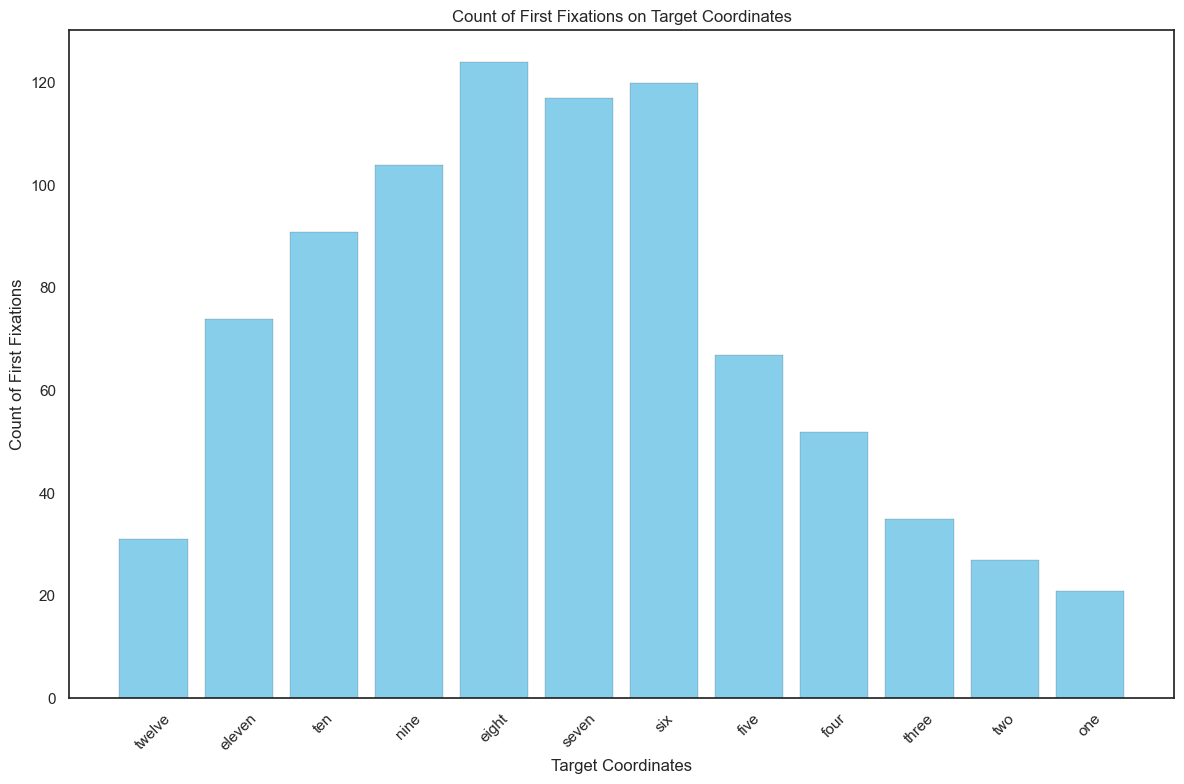

In [211]:
plt.figure(figsize=(12, 8))
reversed_coordinates = sum_df['Coordinate'][::-1]
reversed_count = sum_df['Count'][::-1]
plt.bar(reversed_coordinates, reversed_count, color='skyblue', edgecolor='black', linewidth = 0.1)
plt.xlabel('Target Coordinates')
plt.ylabel('Count of First Fixations')
plt.title('Count of First Fixations on Target Coordinates')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

**Clock-wise layout of results** 

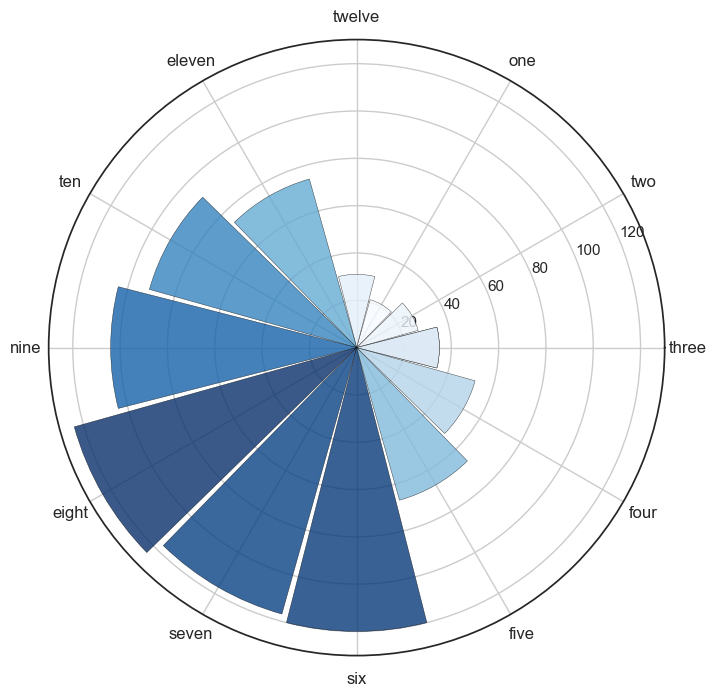

In [212]:
# Die Kategorien in der gewünschten Reihenfolge umsortieren
categories = ['three', 'two', 'one','twelve', 'eleven', 'ten', 'nine', 'eight', 'seven', 'six', 'five', 'four']

# Die Werte in der Reihenfolge der Kategorien anordnen
values = sum_df.set_index('Coordinate').reindex(categories)['Count'].fillna(0).values

# Anzahl der Kategorien
num_vars = len(categories)

# Winkel für jedes Segment berechnen
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Werte für den geschlossenen Radialplot erweitern
values = np.concatenate((values,[values[0]]))
angles += angles[:1]

# Colormap definieren (eine Farbe mit unterschiedlichen Intensitäten)
cmap = plt.cm.Blues  # Blau als Basisfarbe
norm = Normalize(vmin=min(values), vmax=max(values))
colors = cmap(norm(values))

# Plot erstellen
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Balken für jedes Segment erstellen
bars = ax.bar(angles, values, width=0.5, color=colors, edgecolor='black', linewidth=0.3, alpha=0.8)

# Kategorien als Beschriftungen setzen
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, ha='center')

plt.show()

**Percentual comparison for the different stimuli pairs** 

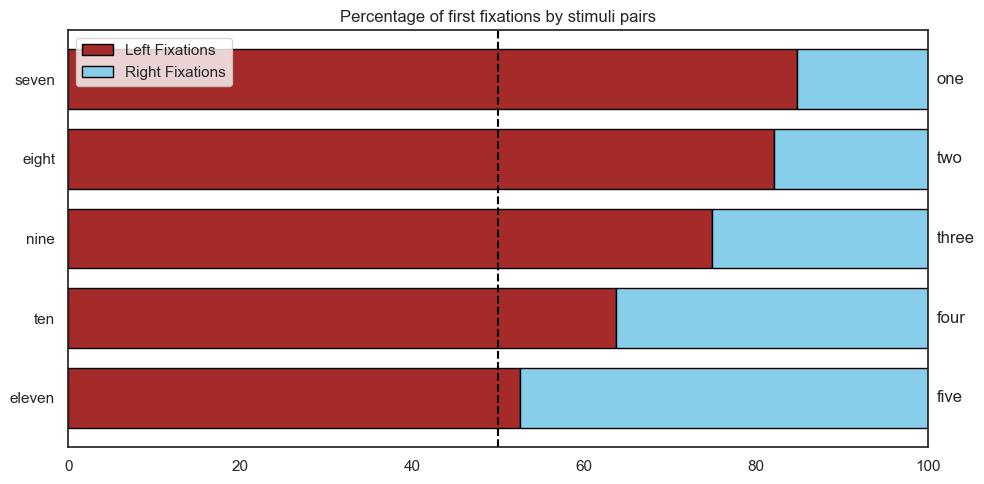

In [213]:
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), ('eleven', 'five')]

# Calculte the sum for each pair
pair_sums = []
for coord1, coord2 in pairs:
    count1 = sum_df[sum_df['Coordinate'] == coord1]['Count'].values[0]
    count2 = sum_df[sum_df['Coordinate'] == coord2]['Count'].values[0]
    total = count1 + count2
    pair_sums.append((coord1, coord2, count1 / total, count2 / total))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Reverse the order of the pairs
pair_sums = pair_sums[::-1]

# Prepare values for the diagram
left_description = [f'{pairs[4-i][0]}' for i in range(0, len(pair_sums))]
right_description = [f'{pairs[4-i][1]}' for i in range(0, len(pair_sums))]
left_fixations = [left for _, _, left, _ in pair_sums]
right_fixations = [right for _, _, _, right in pair_sums]

# Upgrade values to percent
left_fixations = [i * 100 for i in left_fixations]
right_fixations = [i * 100 for i in right_fixations]


# Create plot
bar_width = 0.75
y = np.arange(len(left_description))

# Create left and right bars
ax.barh(y, left_fixations, color='brown', height=bar_width, edgecolor='black', label='Left Fixations')
ax.barh(y, right_fixations, left=left_fixations, color='skyblue', height=bar_width, edgecolor='black', label='Right Fixations')

# Add center line
ax.axvline(50, color='black', linestyle='--')

# Define labels and titel
ax.set_yticks(y)
ax.set_yticklabels(left_description)
#ax.set_xlabel('Percentage of first fixations to the left | right')
ax.set_title('Percentage of first fixations by stimuli pairs')
ax.legend()

# Add right side labels
for i in range(len(y)):
    ax.text(101, y[i], right_description[i], va='center')

# Adjust x-axis from 0 to 100
ax.set_xlim(0, 100)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Pairwise comparison of stimuli pairs**

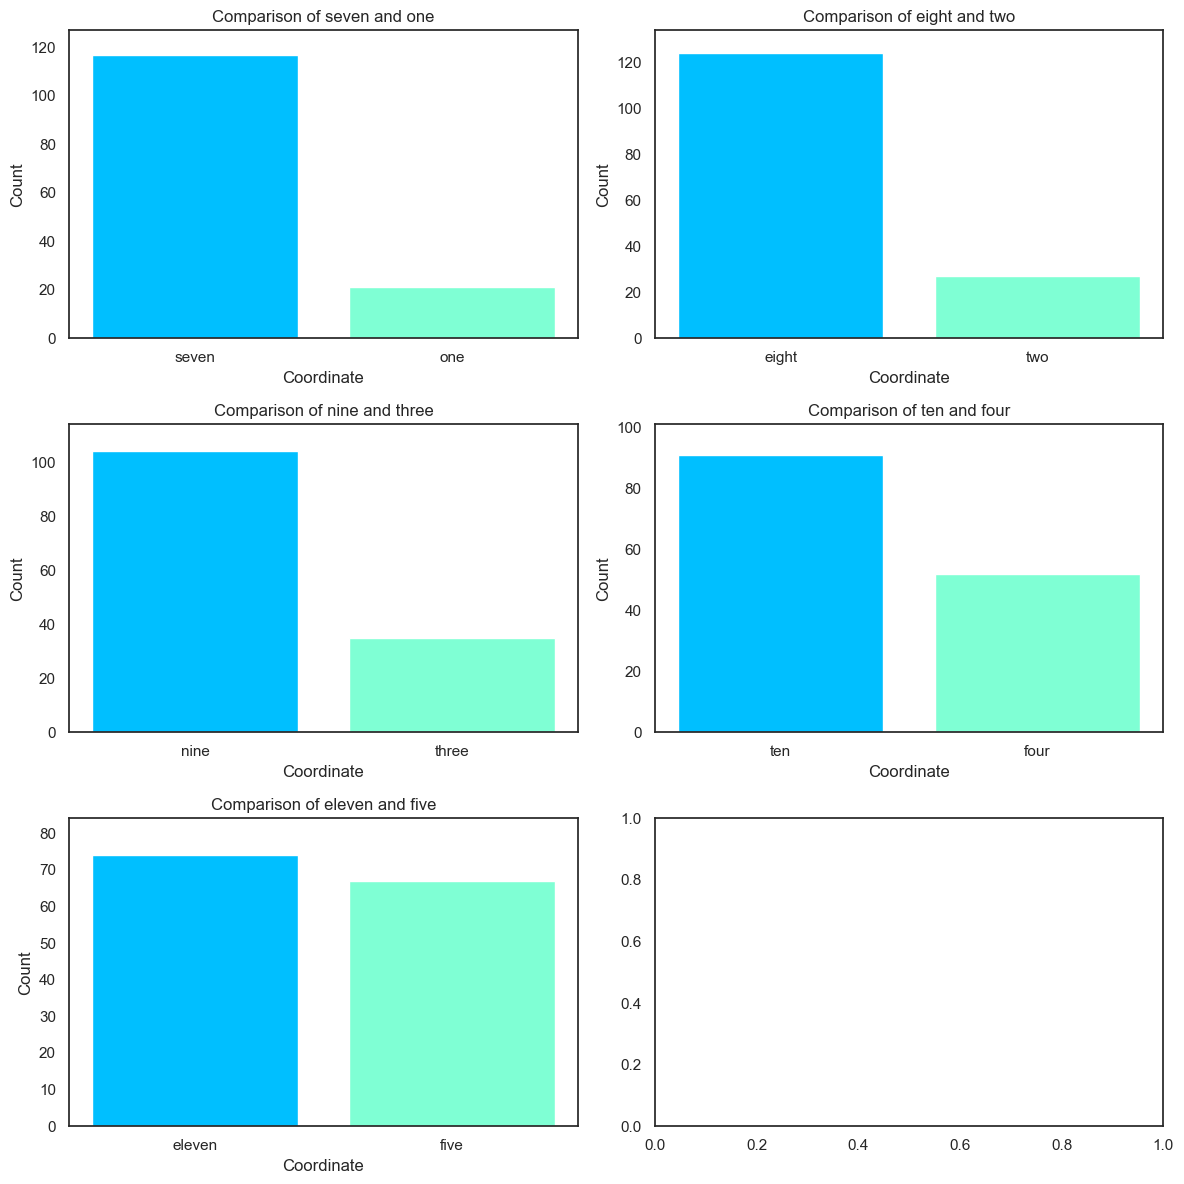

In [214]:
# Create one histogram for every pair
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Iterate over every pair
for i, pair in enumerate(pairs):
    row = i // 2
    col = i % 2
    coord1, coord2 = pair
    
    # Daten für das aktuelle Paar auswählen
    data1 = sum_df[sum_df['Coordinate'] == coord1]['Count']
    data2 = sum_df[sum_df['Coordinate'] == coord2]['Count']
    
    # Sicherstellen, dass Daten vorhanden sind
    if len(data1) == 0 or len(data2) == 0:
        continue
    
    # Define positions for bars on the x-axis
    x = [1, 2]

    # Define height
    height1 = data1.values[0]
    height2 = data2.values[0]

    # Define labels for the x-axis
    labels = [coord1, coord2]

    # Define colors for the bars
    bar_colors = ['#00BFFF', '#7FFFD4']

    # Create histogram and define titles and axis-limits
    axs[row, col].bar(x, [height1, height2], tick_label=labels, color=bar_colors)
    axs[row, col].set_title(f'Comparison of {coord1} and {coord2}')
    axs[row, col].set_xlabel('Coordinate')
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_ylim(0, max(height1, height2) + 10)

# Optimize layout and show plots
plt.tight_layout()
plt.show()

### Sanity Checks
Testing the used data for some possible problems. In the current case, the last example from the loop above is used. To see the event frequency for all participant, include the method *check_balancing_erros* into the loop.

In [218]:
# df is the dataframe for the last participant
check_balancing_errors(df)

Event frequency in the 'USER' column:
USER
SHOW_STIMULUS                        48
START_SEQUENCE                       47
HIDE_STIMULUS                        46
STOP_SEQUENCE                        43
STIMULI: (011.PNG, 020.PNG)           4
COORDINATES:(-160,-277, 160, 277)     4
COORDINATES:(277,160, -277, -160)     4
COORDINATES:(320,0, -320, 0)          4
COORDINATES:(0,-320, 0, 320)          4
COORDINATES:(0,320, 0, -320)          4
COORDINATES:(277,-160, -277, 160)     4
COORDINATES:(-320,0, 320, 0)          4
COORDINATES:(-277,-160, 277, 160)     4
STIMULI: (009.PNG, 011.PNG)           4
COORDINATES:(160,277, -160, -277)     4
COORDINATES:(-277,160, 277, -160)     3
COORDINATES:(160,-277, -160, 277)     3
COORDINATES:(-160,277, 160, -277)     2
STIMULI: (021.PNG, 009.PNG)           2
STIMULI: (004.PNG, 018.PNG)           2
STIMULI: (007.PNG, 010.PNG)           2
STIMULI: (017.PNG, 013.PNG)           2
STIMULI: (005.PNG, 000.PNG)           2
STIMULI: (000.PNG, 021.PNG)          